   # Corn Leaves Desease Detection

In [1]:
#Importing necessary libraries
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from pylab import savefig
import torch
from torchvision import datasets, transforms, models
from torch import nn, optim
import torch.nn.functional as F
from collections import OrderedDict
from PIL import Image
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

In [2]:
#loading data from the directory into my notebook
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        path = os.path.join(dirname, filename)
        print(path)

/kaggle/input/corn-leaves/cornleaves_disease/test/stewart/stewart46.jpg
/kaggle/input/corn-leaves/cornleaves_disease/test/stewart/stewart48.jpg
/kaggle/input/corn-leaves/cornleaves_disease/test/stewart/stewart41.jpg
/kaggle/input/corn-leaves/cornleaves_disease/test/stewart/stewart50.jpg
/kaggle/input/corn-leaves/cornleaves_disease/test/stewart/stewart43.jpg
/kaggle/input/corn-leaves/cornleaves_disease/test/stewart/stewart45.jpg
/kaggle/input/corn-leaves/cornleaves_disease/test/stewart/stewart47.jpg
/kaggle/input/corn-leaves/cornleaves_disease/test/stewart/stewart42.jpg
/kaggle/input/corn-leaves/cornleaves_disease/test/stewart/stewart44.jpg
/kaggle/input/corn-leaves/cornleaves_disease/test/stewart/stewart49.jpg
/kaggle/input/corn-leaves/cornleaves_disease/test/eyespot/eyespot10.jpg
/kaggle/input/corn-leaves/cornleaves_disease/test/eyespot/eyespot9.jpg
/kaggle/input/corn-leaves/cornleaves_disease/test/eyespot/eyespot3.jpg
/kaggle/input/corn-leaves/cornleaves_disease/test/eyespot/eyespot1

## Setting Corn images data directories

In [3]:
#Navigate to the data directory
data_dir = '/kaggle/input/corn-leaves/cornleaves_disease'

image_dir = {
                'train' : data_dir + '/train',
                'test' : data_dir + '/test'
            }

## Transforming and loading the Images data

In [4]:
# implement random scaling, cropping and flipping transformations on the training and test set in a dictionary
image_transforms = {
                    'train' : transforms.Compose([
                                     transforms.RandomRotation(30),
                                     transforms.Resize(224),
                                     transforms.CenterCrop(224),
                                     transforms.RandomResizedCrop(224),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406],
                                                        [0.229, 0.224, 0.225])
                                      ]),

                    'test' :  transforms.Compose([transforms.Resize(224),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            std=[0.229, 0.224, 0.225])])

                    }

#Load the datasets with ImageFolder in a dictionary
image_dataset = {
                    'train' : datasets.ImageFolder(image_dir['train'], transform=image_transforms['train']),
                    'test' : datasets.ImageFolder(image_dir['test'], transform=image_transforms['test'])
                }

#define the dataloaders using the image datasets and the transforms in a dictionary
image_loader = {
                'train' : torch.utils.data.DataLoader(image_dataset['train'], batch_size=32, shuffle=True),
                'test' : torch.utils.data.DataLoader(image_dataset['test'], batch_size=32)
                }

In [5]:
#confirm the shape
x, y = next(iter(image_loader['train']))

print(y.shape)
#check the input shape
x[0][0]

torch.Size([32])


tensor([[-0.0629, -0.7822, -1.2274,  ..., -0.1657, -0.1314, -0.2513],
        [ 0.3309, -0.4911, -1.0562,  ..., -0.1143, -0.0972, -0.0287],
        [ 0.9303, -0.0116, -0.8164,  ..., -0.1486, -0.0287,  0.3652],
        ...,
        [-1.1418, -1.1589, -1.1589,  ..., -2.1179, -2.1179, -2.1179],
        [-1.1418, -1.1589, -1.1589,  ..., -2.1179, -2.1179, -2.1179],
        [-1.1418, -1.1589, -1.1589,  ..., -2.1179, -2.1179, -2.1179]])

In [6]:
# Choosing and checking the pretrained model architecture
model = models.densenet121(pretrained=True)
#model

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

In [7]:
# setting computing device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


## Building the model

In [8]:
# Define the model
    
def my_model(chosen_model):
    """
    defines a new model by modifying the chosen model classifier and defining 
    new model parameters, uses dropout method to prevent overfitting and get
    the model ready for classification
    
    parameters:
        chosen_model - chosen pretrained model to build on 
        
    Returns:
        model -  new model that is built from the pretrained model
        such that it is suitable for corn leaves disease multiclass classification
        task at hand
    
    """
    model = chosen_model
    #loop through the model parameters
    for param in model.parameters():
        #freeze parameters such that backpropagation do not happen through them
        param.requires_grad = False
        #Define model hyperparameters
        input = 1024
        hidden = 256
        output_size = 5
        pr_dropout = 0.2
        epochs = 5
        learnrate = 0.003
        #Move the model to an available computing device
        model.to(device)
        #define the new model classifier
        modelSequence = nn.Sequential(OrderedDict([
            
            ('fc1', nn.Linear(input, hidden)),
            ('relu', nn.ReLU()),
            ('dropout', nn.Dropout(pr_dropout)), #randomly drop input units to reduce overfitting using dropout
            ('fc2', nn.Linear(hidden, output_size)),
            ('output', nn.LogSoftmax(dim=1))
            
        ]))
        
    #Overrite the pretrained model classifier with the defined classifier
    model.classifier = modelSequence
    #Move the newly defined model to the available computing device
    model.to(device)
    return model
    


In [9]:
#Choose model criterion and optimizer and put them in a dictionary
model = my_model(models.densenet121(pretrained=True))

hyper = {
            # set appropriate loss criterion for log softmax model output
            'criterion' : nn.NLLLoss().to(device),
            # Only trains the classifier parameters, feature parameters are frozen
            'optimizer' : optim.Adam(model.classifier.parameters(), lr=0.003)     
        }

## Training model

In [10]:
# Writing a function for the training loop
def learning(model, loader, epochs, print_every, criterion = hyper['criterion'], 
    optimizer = hyper['optimizer'], device='cuda'):
    """
    implements the training loop comprises of feed forward, loss calculation
    and gradient descents through backpropagation and repeatedly nudge the weight 
    and bias for improved network learning
    
    parameters:
        model - new model that is built from the pretrained model
            such that it is suitable for corn leaves disease multiclass classification
            task at hand
            
        loader - image loader holding both the images and labels
        
        print_every - Average number of epoch values to be printed
        
        criterion - carefully chosen loss criterion 
        
    prints:
        Epoch - value of the present epoch
        Loss - average loss at every epoch per print_every times
        
    """
    #set initial values for steps and running loss
    steps =0
    running_loss = 0
    model.to(device)
    
    for epoch in range(epochs):
        
       
        #loop through the image loader
        for images, labels in loader:
            steps += 1 #update the step value
            #Move the running image and label to the available device 
            images, labels = images.to(device), labels.to(device)
            
            
            optimizer.zero_grad()
            # feed forward
            output = model(images)
            #calculates the loss
            loss = criterion(output, labels)
            #compute the gradient
            loss.backward()
            # Update the weight
            optimizer.step()
            
            running_loss += loss.item()
            #display epoch and running loss every print_every steps
            if steps % print_every == 0:
                
                print("Epoch: {}/{}".format(epoch+1, epochs),
                       "Loss: {:.4f}".format(running_loss/print_every))
                
                running_loss = 0
                #set back to training mode
                model.train()

In [11]:

learning(model, image_loader['train'], 60, 10, criterion = hyper['criterion'], 
optimizer = hyper['optimizer'], device='cuda')  

Epoch: 2/60 Loss: 1.5318
Epoch: 3/60 Loss: 1.0058
Epoch: 5/60 Loss: 0.8218
Epoch: 6/60 Loss: 0.7226
Epoch: 8/60 Loss: 0.6366
Epoch: 9/60 Loss: 0.5610
Epoch: 10/60 Loss: 0.5824
Epoch: 12/60 Loss: 0.5504
Epoch: 13/60 Loss: 0.4376
Epoch: 15/60 Loss: 0.4113
Epoch: 16/60 Loss: 0.4316
Epoch: 18/60 Loss: 0.5059
Epoch: 19/60 Loss: 0.4461
Epoch: 20/60 Loss: 0.4780
Epoch: 22/60 Loss: 0.6085
Epoch: 23/60 Loss: 0.5623
Epoch: 25/60 Loss: 0.6584
Epoch: 26/60 Loss: 0.3655
Epoch: 28/60 Loss: 0.5412
Epoch: 29/60 Loss: 0.5509
Epoch: 30/60 Loss: 0.4368
Epoch: 32/60 Loss: 0.4319
Epoch: 33/60 Loss: 0.3434
Epoch: 35/60 Loss: 0.3287
Epoch: 36/60 Loss: 0.4284
Epoch: 38/60 Loss: 0.3351
Epoch: 39/60 Loss: 0.2997
Epoch: 40/60 Loss: 0.3628
Epoch: 42/60 Loss: 0.4186
Epoch: 43/60 Loss: 0.3643
Epoch: 45/60 Loss: 0.3139
Epoch: 46/60 Loss: 0.4225
Epoch: 48/60 Loss: 0.3155
Epoch: 49/60 Loss: 0.3644
Epoch: 50/60 Loss: 0.3661
Epoch: 52/60 Loss: 0.3209
Epoch: 53/60 Loss: 0.3997
Epoch: 55/60 Loss: 0.4420
Epoch: 56/60 Loss:

## Evaluating model performance and result presentation using confusion matrix

In [12]:
# validation on the test set
def test_metrics(testloader = image_loader['test'] ):
    """
    gets the true value and the predicted value in a list container
    to be used for the representation of the overall performance of
    the model using confusion matrix
    
    Parameter:
        testloader - image_loader containing the test set inputs and 
        labels for model performance evaluation purpose
        
    Returns:
        y_true - list of True numerically encoded label of the input value
        y_pred - list of Predicted numerically encoded label of the input value
    """
    y_true = []
    
    y_pred = []
    
    accuracy = 0
    #set model to evaluation mode
    model.eval()
    #turn off gradients
    with torch.no_grad():
        #validation pass on the test set
        for inputs, labels in testloader:
            #moving inpts to the appropriate device
            inputs, labels = inputs.to(device), labels
            #convert labels to numpy array for use outside of torch and appen to y_true
            y_true.extend(labels.numpy())
            #compute the forward pass
            logps = model.forward(inputs)
            #take the exponential of the logarithmic output to get the real predicted value
            ps = torch.exp(logps)
            _, predicted = torch.max(ps, 1)
            #return the predicted value to cpu for access outside of cuda
            y_pred.extend(predicted.cpu().numpy())
            
    #set model back to training mode        
    model.train()
    return y_true, y_pred

In [13]:
y_true, y_pred = test_metrics()
#y_true

In [14]:
#calculate the confusion matrix 
cf_matrix = confusion_matrix(y_true, y_pred)

In [15]:
class_names = ('eyespot', 'goss wilt', 'healthy', 'physoderma Brown Spot', 'stewart bacterial wilt' )

In [16]:
#compute and display the confusion matrix in a dataframe
dataframe = pd.DataFrame(cf_matrix, index=class_names, columns=class_names)

In [17]:
#save confusion matrix dataframe
dataframe.to_csv('matrix_df.csv')

dataframe

,eyespot,goss wilt,healthy,physoderma Brown Spot,stewart bacterial wilt
eyespot,7,2,0,0,1
goss wilt,0,7,0,2,1
healthy,0,0,10,0,0
physoderma Brown Spot,0,0,0,10,0
stewart bacterial wilt,0,0,0,0,10


## Presenting confusion matrix in a Heatmap

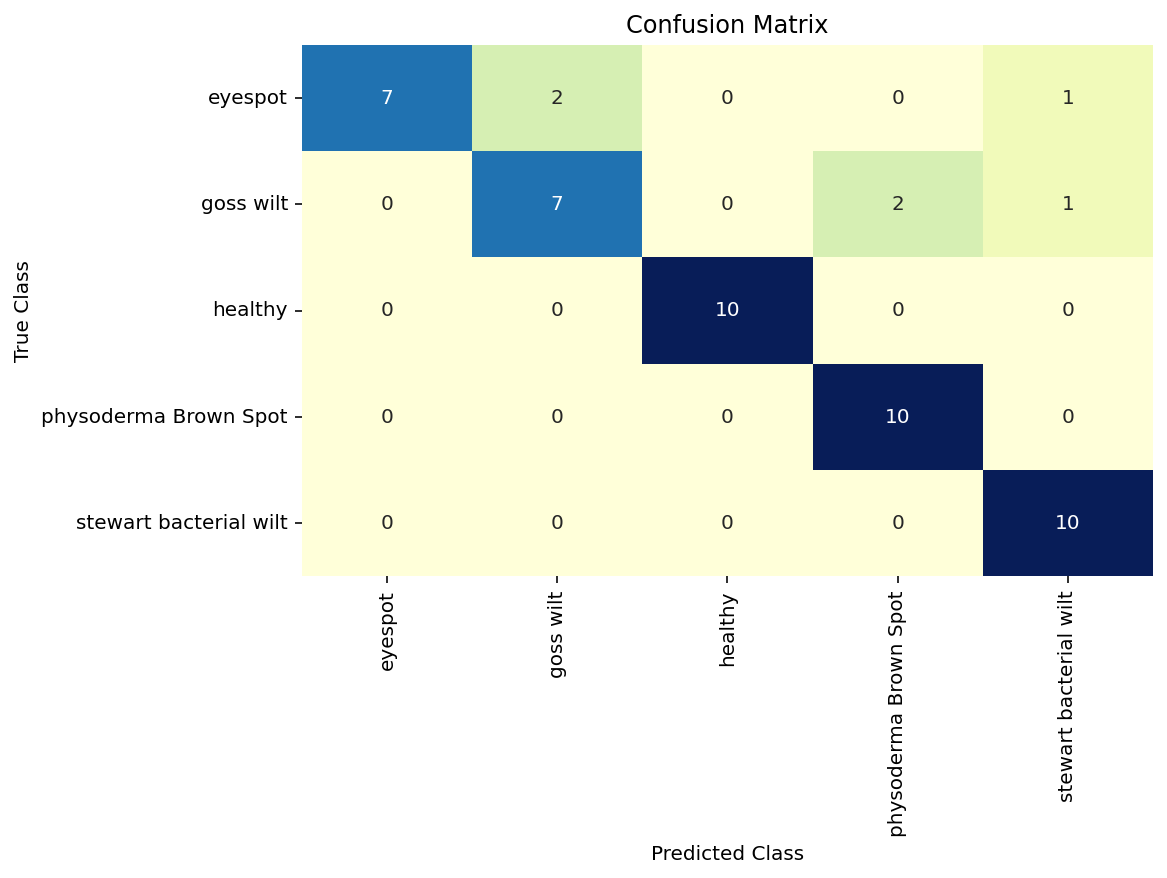

In [27]:
#Display the confusion matrix as stated in the question in a form of a heatmap
plt.figure(figsize=(8, 6))

# Create heatmap
cfm = sns.heatmap(dataframe, annot=True, cbar=None,cmap="YlGnBu",fmt="d")
cfm
#set title
plt.title("Confusion Matrix"), plt.tight_layout()

#set Y label
plt.ylabel("True Class"), 
#set X label
plt.xlabel("Predicted Class")
#display the heatmap
plt.show()
figure = cfm.get_figure() 
#save confusion matrix heatmap
figure.savefig('confusion_matrix_heatmap.png', dpi=300)

## Calculating Precision, recall and F1 score for every classes

In [19]:
def set_label(y_list, labels=class_names):
    """
    replace the integer value of ith item in a list by their corresponding
    class name
    
    parameters:
        y_list - list of either the true value of y or the predicted value of y
        label - tuple of class names
    
    returns:
        y_list - y_list with each previous items changed in-place to their 
        corresponding class names
    
    """
    #iterate through the y_list
    for i in range(len(y_list)):
        #Keep changing integer value to their corresponding class names till the end of the list is reached
        if y_list[i]==0:
            y_list[i]=labels[0]
        
        elif y_list[i]==1:
            y_list[i]=labels[1]
        
        elif y_list[i]==2:
            y_list[i]=labels[2]
        
        elif y_list[i]==3:
            y_list[i]=labels[3]
        
        elif y_list[i]==4:
            y_list[i]=labels[4]
        else:
            pass
    
    return list(y_list)

In [20]:
set_label(y_true)

['eyespot',
 'eyespot',
 'eyespot',
 'eyespot',
 'eyespot',
 'eyespot',
 'eyespot',
 'eyespot',
 'eyespot',
 'eyespot',
 'goss wilt',
 'goss wilt',
 'goss wilt',
 'goss wilt',
 'goss wilt',
 'goss wilt',
 'goss wilt',
 'goss wilt',
 'goss wilt',
 'goss wilt',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'physoderma Brown Spot',
 'physoderma Brown Spot',
 'physoderma Brown Spot',
 'physoderma Brown Spot',
 'physoderma Brown Spot',
 'physoderma Brown Spot',
 'physoderma Brown Spot',
 'physoderma Brown Spot',
 'physoderma Brown Spot',
 'physoderma Brown Spot',
 'stewart bacterial wilt',
 'stewart bacterial wilt',
 'stewart bacterial wilt',
 'stewart bacterial wilt',
 'stewart bacterial wilt',
 'stewart bacterial wilt',
 'stewart bacterial wilt',
 'stewart bacterial wilt',
 'stewart bacterial wilt',
 'stewart bacterial wilt']

In [21]:
set_label(y_pred)

['eyespot',
 'eyespot',
 'eyespot',
 'eyespot',
 'goss wilt',
 'eyespot',
 'eyespot',
 'stewart bacterial wilt',
 'eyespot',
 'goss wilt',
 'goss wilt',
 'goss wilt',
 'goss wilt',
 'stewart bacterial wilt',
 'goss wilt',
 'physoderma Brown Spot',
 'goss wilt',
 'physoderma Brown Spot',
 'goss wilt',
 'goss wilt',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'physoderma Brown Spot',
 'physoderma Brown Spot',
 'physoderma Brown Spot',
 'physoderma Brown Spot',
 'physoderma Brown Spot',
 'physoderma Brown Spot',
 'physoderma Brown Spot',
 'physoderma Brown Spot',
 'physoderma Brown Spot',
 'physoderma Brown Spot',
 'stewart bacterial wilt',
 'stewart bacterial wilt',
 'stewart bacterial wilt',
 'stewart bacterial wilt',
 'stewart bacterial wilt',
 'stewart bacterial wilt',
 'stewart bacterial wilt',
 'stewart bacterial wilt',
 'stewart bacterial wilt',
 'stewart bacterial wilt']

In [28]:
# Calculate precision recall and f1 score metrics
metric = precision_recall_fscore_support(y_true, y_pred, average=None,labels=list(class_names))

df = pd.DataFrame(metric, columns = list(class_names), index=['%precision score', '%recall score', '%f1 score', 'value count'])
# round df to the nearest decimal
df = df.round(2)
#calculate percentage of all metrics in df
df[:-1] = df[:-1]*100
#save dataframe in csv format
df.to_csv('conf_matrix_dataframe.csv')

df

,eyespot,goss wilt,healthy,physoderma Brown Spot,stewart bacterial wilt
%precision score,100.0,78.0,100.0,83.0,83.0
%recall score,70.0,70.0,100.0,100.0,100.0
%f1 score,82.0,74.0,100.0,91.0,91.0
value count,10.0,10.0,10.0,10.0,10.0


In [23]:
#round value to the nearest decimal
metric = np.round_(metric[:3], decimals = 3)*100

metric

array([[100. ,  77.8, 100. ,  83.3,  83.3],
       [ 70. ,  70. , 100. , 100. , 100. ],
       [ 82.4,  73.7, 100. ,  90.9,  90.9]])

In [24]:
# display Precision metric in percentage for each class
print('eyespot precision: ', metric[0][0], '\ngoss wilt precision: ', round(metric[0][1], 3), '\nhealthy precision: ', metric[0][2], 
      '\nphysoderma Brown Spot: ', metric[0][3], '\nstewart bacterial wilt precision: ', metric[0][4])

eyespot precision:  100.0 
goss wilt precision:  77.8 
healthy precision:  100.0 
physoderma Brown Spot:  83.3 
stewart bacterial wilt precision:  83.3


In [25]:
# display Recall metric in percentage for each class
print('eyespot recall: ', metric[1][0], '\ngoss wilt recall: ', metric[1][1], '\nhealthy recall: ', metric[1][2], 
      '\nphysoderma Brown Spot recall : ', metric[1][3], '\nstewart bacterial wilt recall: ', metric[1][4])

eyespot recall:  70.0 
goss wilt recall:  70.0 
healthy recall:  100.0 
physoderma Brown Spot recall :  100.0 
stewart bacterial wilt recall:  100.0


In [26]:
# display F1 score metric in percentage for each class
print('eyespot f1: ', round(metric[2][0], 3), '\ngoss wilt f1: ', metric[2][1], '\nhealthy f1: ', metric[2][2],
      '\nphysoderma Brown Spot f1 : ', metric[2][3], '\nstewart bacterial wilt f1: ', metric[2][4])

eyespot f1:  82.4 
goss wilt f1:  73.7 
healthy f1:  100.0 
physoderma Brown Spot f1 :  90.9 
stewart bacterial wilt f1:  90.9
